In [2]:
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
import torch.nn as nn
import torch.optim as optim
from training import ClassifierTrainer
from classifier import VanillaClassifier
from utils import set_random_seeds, vec_to_img, get_fmnist_functa
from plot import plot_fit

data_path = '/datasets/functaset'
num_classes = 10
in_features = 512
checkpoint_file = 'checkpoints/mlp'
num_epochs = 500
early_stopping = 5
lr = 1e-3
hidden_dims = [512, 256, 128]
p_dropout = 0.1
batch_size = 64
normalization = "batch"
activations = ["lrelu"]*len(hidden_dims)


loss_fn = nn.CrossEntropyLoss()
set_random_seeds(0)
train_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_train.pkl", mode='train',
                                                   batch_size=batch_size, num_workers=2)
val_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_val.pkl", mode='test',
                                                 batch_size=batch_size, num_workers=2)

model = VanillaClassifier(in_features=in_features, num_classes=num_classes, hidden_dims=hidden_dims,
                                      nonlins=activations, p_dropout=p_dropout,
                                      normalization=normalization).to(device)
print(model)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.1, patience=3, verbose=True)

def post_epoch_fn(epoch, train_res, test_res, verbose):
    scheduler.step(test_res.accuracy)

trainer = ClassifierTrainer(model, loss_fn, optimizer, device)

# Train, unless final checkpoint is found
checkpoint_file_final_prefix = f'{checkpoint_file}_final'
checkpoint_file_final = f'{checkpoint_file_final_prefix}.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:

        fit_res = trainer.fit(train_functaloader, val_functaloader, num_epochs, max_batches=None,
                                  post_epoch_fn=post_epoch_fn, early_stopping=early_stopping,
                                  checkpoints=checkpoint_file_final_prefix, print_every=1)
        fig, axes = plot_fit(fit_res)
        print(f"last checkpoint idx: {fit_res.last_checkpoint_idx}")
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

VanillaClassifier(
  (net): MLP(
    (layers): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=256, out_features=128, bias=True)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=128, out_features=10, bias=True)
      (13): Identity()
    )
  )
)
*** Loading final checkpoint file checkpoints/mlp_final.pt instead of training


In [5]:
import torch

def evaluate_model(model, dataloader, device):
    """
    Evaluates the model on a given dataloader and returns accuracy.
    
    Args:
    - model: The trained model to evaluate.
    - dataloader: DataLoader providing the dataset to evaluate on.
    - device: The device to run the evaluation on ('cuda' or 'cpu').
    
    Returns:
    - accuracy: Accuracy of the model on the provided data.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation during inference
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Get predicted class (argmax over the outputs)
            predicted = torch.argmax(y_pred, dim=1)

            # Accumulate the total and correct predictions
            correct += (predicted == y).sum().item()
            total += y.size(0)
    
    # Calculate accuracy
    accuracy = correct / total
    return accuracy


In [7]:
train_accuracy = evaluate_model(model, train_functaloader, device)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

validation_accuracy = evaluate_model(model, val_functaloader, device)
print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

test_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_test.pkl", mode='test', batch_size=batch_size, num_workers=2)
test_accuracy = evaluate_model(model, test_functaloader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Train Accuracy: 98.47%
Validation Accuracy: 89.66%
Test Accuracy: 89.20%


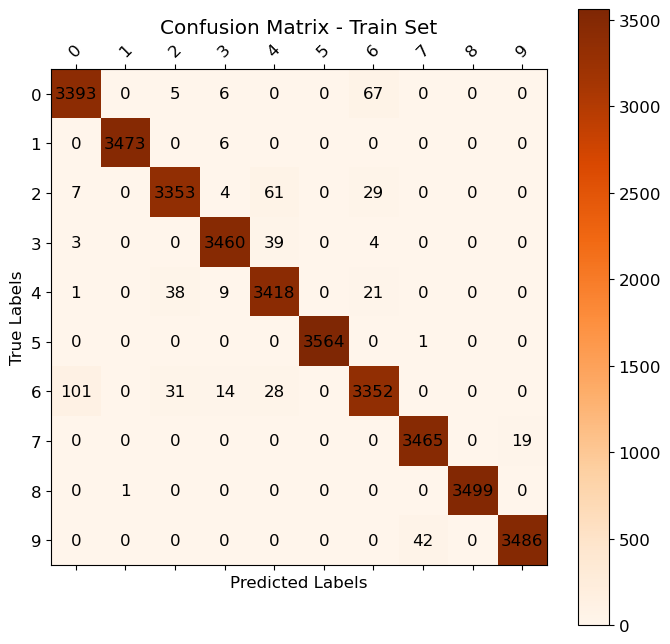

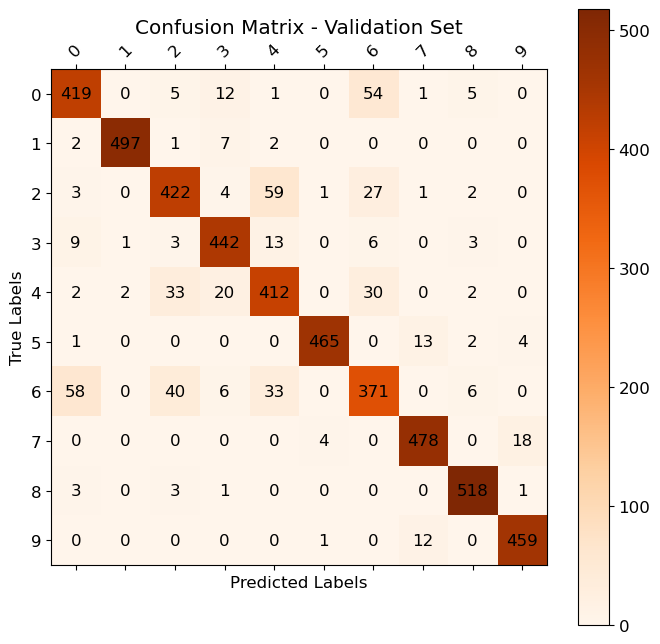

NameError: name 'test_functaloader' is not defined

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_and_plot_confusion_matrix(model, dataloader, class_names, device, title):
    model.eval()
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = torch.argmax(model(X), dim=1)
            true_labels.append(y.cpu().numpy())
            pred_labels.append(y_pred.cpu().numpy())

    # Flatten lists and compute confusion matrix
    cm = confusion_matrix(np.concatenate(true_labels), np.concatenate(pred_labels))
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.xticks(rotation=45)

    # Annotate cells
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.show()

# Example usage:
class_names = [str(i) for i in range(10)]  # Assuming 10 classes labeled 0-9

# Plot confusion matrices for Train, Validation, and Test sets
evaluate_and_plot_confusion_matrix(model, train_functaloader, class_names, device, "Confusion Matrix - Train Set")
evaluate_and_plot_confusion_matrix(model, val_functaloader, class_names, device, "Confusion Matrix - Validation Set")
evaluate_and_plot_confusion_matrix(model, test_functaloader, class_names, device, "Confusion Matrix - Test Set")


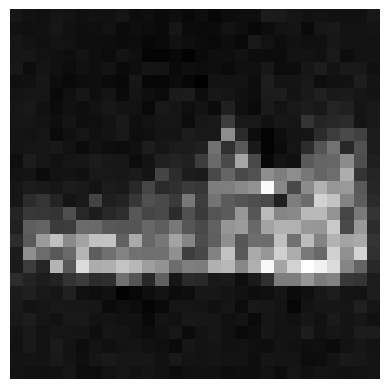

tensor(7)


In [35]:
from utils import set_random_seeds, vec_to_img, get_fmnist_functa
import numpy as np
from SIREN import ModulatedSIREN
# Load Full INR - this is only for visualization purposes - this is just an example, you can erase this when you submit
inr = ModulatedSIREN(height=28, width=28, hidden_features=256, num_layers=10, modul_features=512)
inr.load_state_dict(torch.load(f"{data_path}/modSiren.pth")['state_dict'])
inr = inr.to(device)

#Example of extracting full image from modulation vector - must pass a single (non-batched) vector input - this is just an example, you can erase this when you submit
img = vec_to_img(inr, train_functaloader.dataset[0][0].to(device))
img_tensor = img.detach().cpu().numpy()
plt.imshow(img_tensor, cmap='gray')  # Specify 'gray' colormap for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()

/home/galkesten/miniconda3/envs/cs236781-project/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


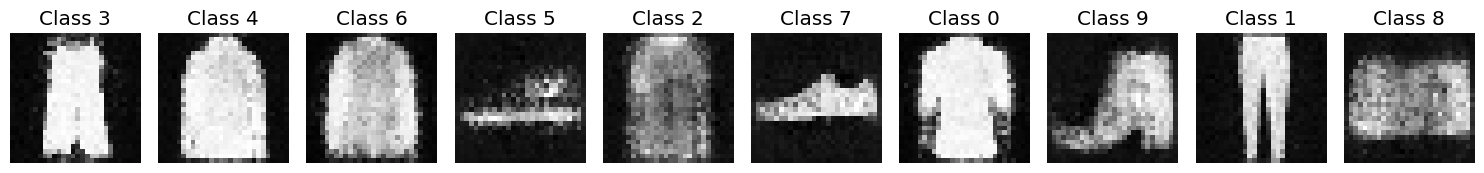

In [7]:
from utils import set_random_seeds, vec_to_img, get_fmnist_functa
import numpy as np
import torch
import matplotlib.pyplot as plt
from SIREN import ModulatedSIREN

# Load Full INR
inr = ModulatedSIREN(height=28, width=28, hidden_features=256, num_layers=10, modul_features=512)
inr.load_state_dict(torch.load(f"{data_path}/modSiren.pth")['state_dict'])
inr = inr.to(device)

# Dictionary to store one example per class
examples_per_class = {}

# Iterate over the training set until we have one example from each class
for data in train_functaloader:
    inputs, labels = data
    for i, label in enumerate(labels):
        if label.item() not in examples_per_class:
            # Extract image using the modulation vector
            img = vec_to_img(inr, inputs[i].to(device))
            img_tensor = img.detach().cpu().numpy()

            # Store the image and label
            examples_per_class[label.item()] = img_tensor

        # Stop if we have examples from all classes
        if len(examples_per_class) == 10:
            break
    if len(examples_per_class) == 10:
        break

# Plot the images
fig, axes = plt.subplots(1, 10, figsize=(15, 15))
class_names = [str(i) for i in range(10)]  # Assuming 10 classes labeled 0-9

for idx, (label, img) in enumerate(examples_per_class.items()):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'Class {class_names[label]}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


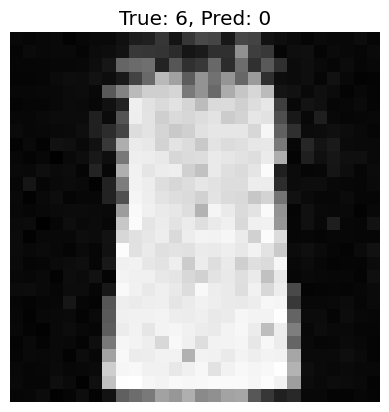

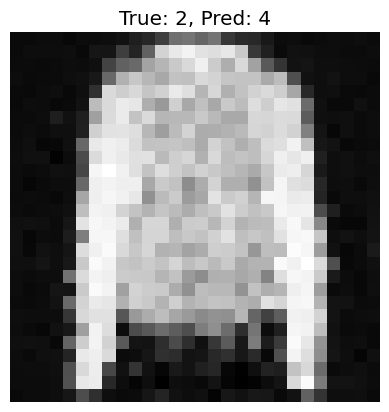

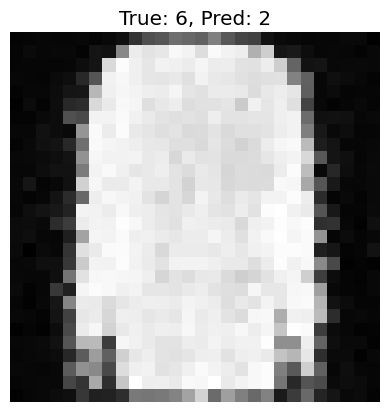

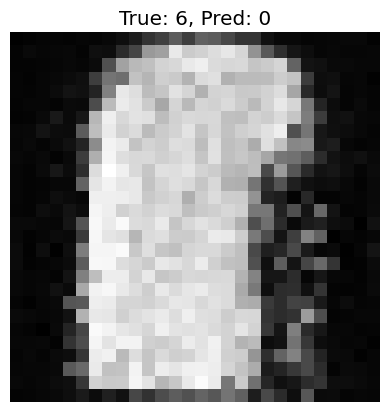

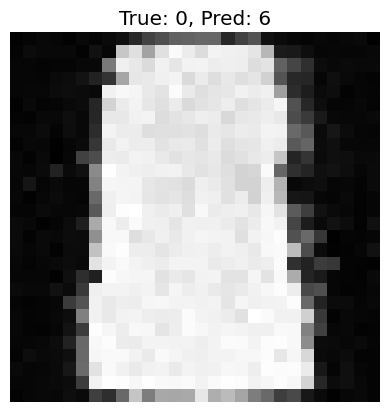

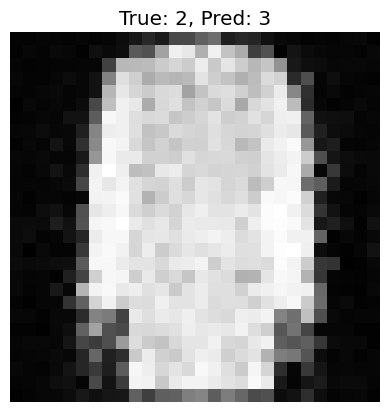

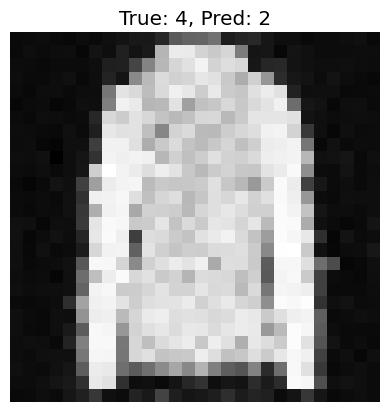

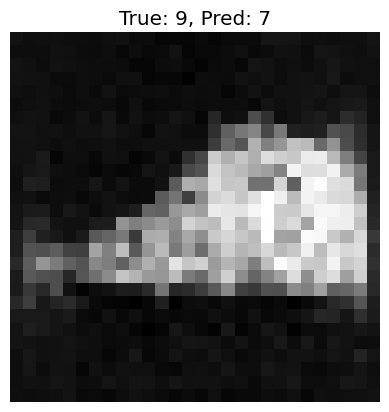

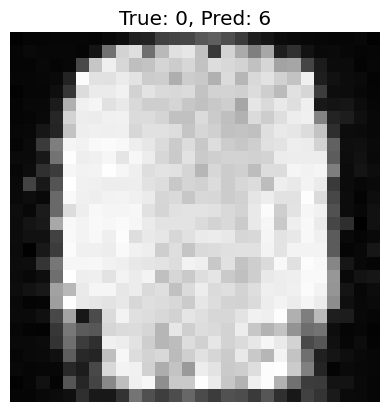

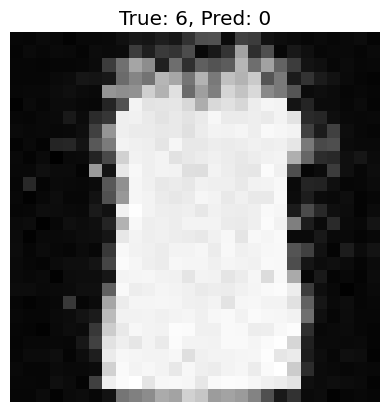

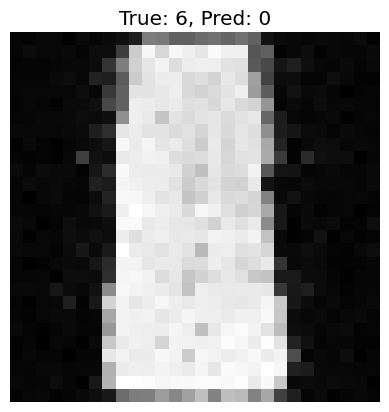

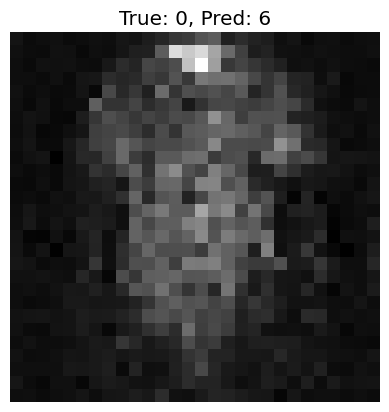

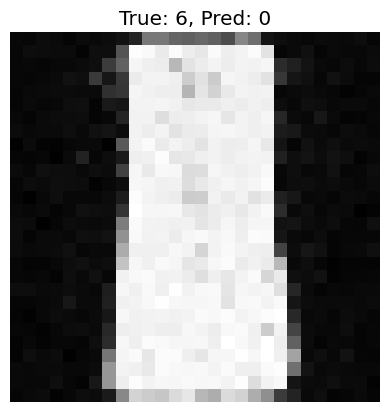

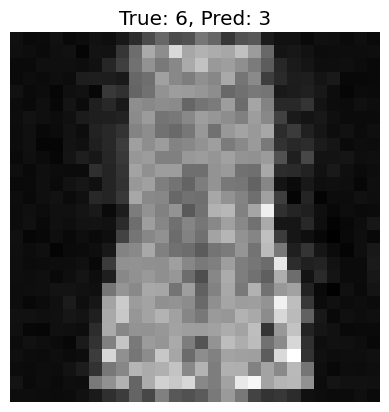

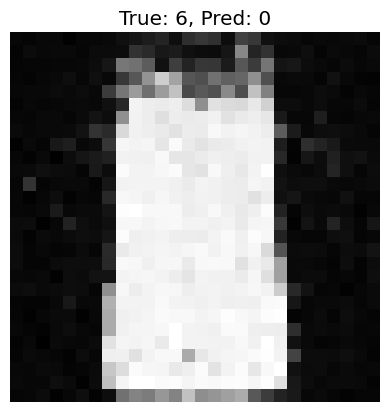

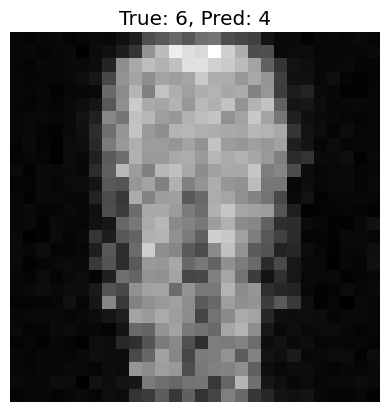

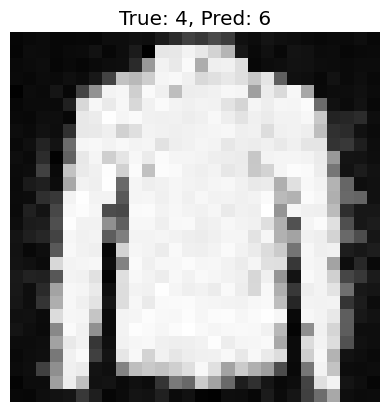

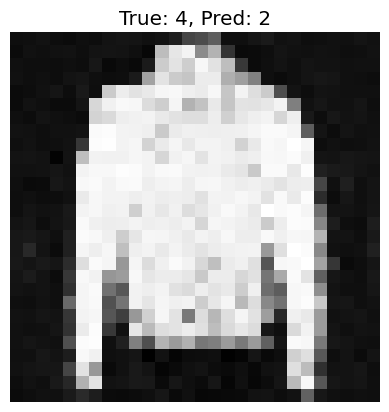

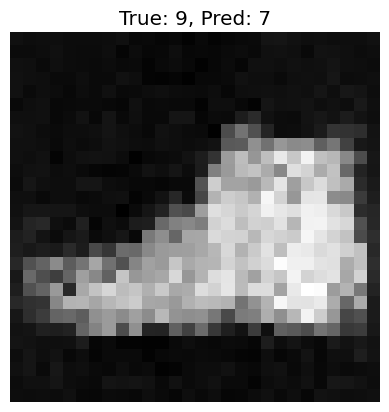

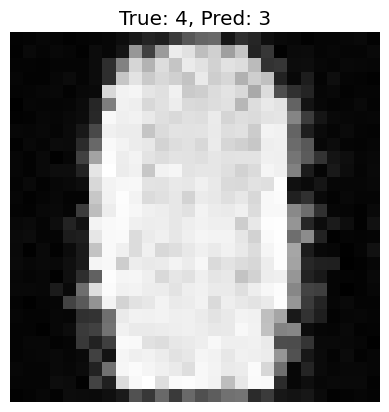

In [8]:
import torch
import matplotlib.pyplot as plt

def plot_misclassified_images(model, dataloader, inr, class_names, device, num_examples_to_show=5):
    """
    Plots examples of misclassified images along with their true and predicted labels.

    Args:
    - model: The trained model.
    - dataloader: DataLoader providing the dataset to evaluate on.
    - inr: The Modulated SIREN used to generate images from modulation vectors.
    - class_names: List of class names.
    - device: The device to run the evaluation on ('cuda' or 'cpu').
    - num_examples_to_show: Number of misclassified examples to plot (default is 5).
    """
    model.eval()
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_pred_labels = []

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = torch.argmax(model(X), dim=1)

            # Find the indices where predictions are wrong
            misclassified_mask = (y_pred != y)  # Boolean mask for misclassified
            misclassified_indices = torch.where(misclassified_mask)[0]  # Indices of misclassified samples

            for idx in misclassified_indices:
                img_tensor = vec_to_img(inr, X[idx]).cpu().detach().numpy()  # Extract image using vec_to_img
                true_label = y[idx].item()  # Get true label
                pred_label = y_pred[idx].item()  # Get predicted label
                
                # Store the misclassified information
                misclassified_images.append(img_tensor)
                misclassified_true_labels.append(true_label)
                misclassified_pred_labels.append(pred_label)

            # Stop collecting if we have enough examples
            if len(misclassified_images) >= num_examples_to_show:
                break

    # Plot the misclassified images
    for i in range(num_examples_to_show):
        plt.imshow(misclassified_images[i], cmap='gray')
        plt.title(f"True: {class_names[misclassified_true_labels[i]]}, Pred: {class_names[misclassified_pred_labels[i]]}")
        plt.axis('off')
        plt.show()

# Example usage:
plot_misclassified_images(model, train_functaloader, inr, class_names, device, num_examples_to_show=20)
